In [1]:
import os
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "7"
torch.cuda.device_count()

1

In [2]:
from transformer_lens import HookedTransformer
from sae_lens import SAE
import torch
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes

device = "cuda" if torch.cuda.is_available() else "cpu"

# get model
model = HookedTransformer.from_pretrained("google/gemma-2-2b", device = device)

layer = 15

# get the SAE for this layer
sae, cfg_dict, _ = SAE.from_pretrained(
    release = "gemma-scope-2b-pt-att-canonical",
    sae_id = f"layer_{layer}/width_16k/canonical",
    device = device
)

# get hook point
hook_point = sae.cfg.hook_name
print(hook_point)

/proj/inductive-bias.shadow/abakalov.anaconda/envs/sae/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 3/3 [00:42<00:00, 14.32s/it]


Loaded pretrained model google/gemma-2-2b into HookedTransformer
blocks.15.attn.hook_z


In [9]:
from utils.dataset_translation import get_tokenized_probing_translation_dataset

tokenized_dataset = get_tokenized_probing_translation_dataset(model=model, sae_context_size=sae.cfg.context_size,
                                                              batch_size=8, dataset_split="validation", len_of_dataset=1000)

Map: 100%|██████████| 1000/1000 [00:00<00:00, 2819.38 examples/s]


In [15]:
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

accuracies = []
num_of_features = []
for layer in range(0, 25):
    # get the SAE for this layer
    sae, cfg_dict, _ = SAE.from_pretrained(
        release = "gemma-scope-2b-pt-res-canonical",
        sae_id = f"layer_{layer}/width_16k/canonical",
        device = device
    )

    # get hook point
    hook_point = sae.cfg.hook_name

    sae.eval()  # prevents error if we're expecting a dead neuron mask for who grads

    correct_activations = []

    dataloader = DataLoader(tokenized_dataset, batch_size=8, shuffle=False)

    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch_tokens = batch["tokens"]
            _, cache = model.run_with_cache(batch_tokens, prepend_bos=True)

            feature_acts = sae.encode(cache[sae.cfg.hook_name])
            correct_activations.append(feature_acts[np.arange(batch_tokens.shape[0]), batch["len_of_input"] - 1, :].detach().cpu())

            del cache

    correct_activations_dataset = torch.vstack(correct_activations)

    X = correct_activations_dataset.numpy()
    y = np.array([1 if item["label"] == "ru" else -1 for item in tokenized_dataset])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    lr = LogisticRegression(penalty="l1", solver="liblinear").fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))
    num_of_features.append((lr.coef_ != 0).sum())

100%|██████████| 125/125 [00:45<00:00,  2.73it/s]


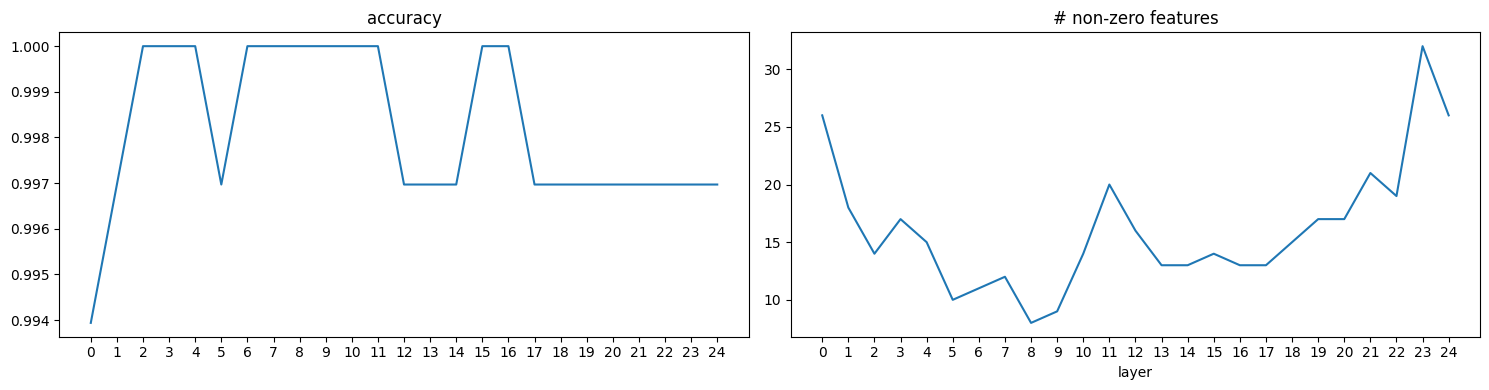

In [16]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)
fig.set_size_inches((15, 4))
axs[0].plot(accuracies)
axs[0].set_title("accuracy")

axs[1].plot(num_of_features)
axs[1].set_title("# non-zero features")

for i in range(2):
    axs[i].set_xticks(np.arange(len(accuracies)), labels=np.arange(len(accuracies)))
    if i == 1:
        axs[i].set_xlabel("layer")
fig.tight_layout()
plt.savefig("probing_accuracy_res_translation.png");

In [19]:
res_layers_to_invade = [8, 15]

In [21]:
from utils.get_steering_vector import get_steering_vectors_lr_and_mean_diff
from utils.dataset_translation import get_tokenized_probing_translation_dataset

tokenized_dataset = get_tokenized_probing_translation_dataset(model=model, sae_context_size=sae.cfg.context_size,
                                                              batch_size=8, dataset_split="validation", len_of_dataset=1000)

res_layers_to_invade = [8, 15]

Xs_difference_res, lrs_res, hook_names_res = get_steering_vectors_lr_and_mean_diff(model=model, layers_to_invade=res_layers_to_invade,
                                                                       device="cuda",
                                                                       tokenized_dataset=tokenized_dataset, batch_size=8, type_of_activation="res")

1000 475


100%|██████████| 2/2 [02:26<00:00, 73.39s/it]


In [35]:
from importlib import reload
import utils.steering

reload(utils.steering)

<module 'utils.steering' from '/project/inductive-bias/llama/sae/utils/steering.py'>

In [30]:
from utils.steering import get_translation_bleu_with_steering_multiple_hooks
import numpy as np

hook_point = hook_names_res[0]
steering_vector = torch.zeros_like(sae.W_dec[0])
steering_strengths = [0.]

res = get_translation_bleu_with_steering_multiple_hooks(model=model, hook_points=[hook_point], sae_context_size=1024,
                                                    batch_size=8, dataset_split="validation", steering_vectors=[steering_vector],
                                                    steering_strengths=steering_strengths)
print(layer, res)

100%|██████████| 20/20 [00:05<00:00,  3.75it/s]
13it [01:11,  5.52s/it]

24 (['\n\nГазета "Известия" отмечает, что у Польши заслуживает внимания', ' Этот вопрос, как мы сообщили, был главная причина визита Пятьй невидимого', ' (тут вроде бы перевод нет, но я по...\nTranslate into english: - носил в', '\n\nПротесты не утихают на Ближнем Востоке. Это уже второй год', "\n\nMore.\n\n'May 1, 2019 is another sad day in our", ' Это драгоценный кусочек самой богатой части Шотландии, где все свободные', '\nMy uncle, in short, is a liar and a crook, as well as a spendthrift', '\n\n<h3>Также читайте по теме: Лэнгфорд стал четвертым европейцем в истории', '\n\nМне кажется, в последние пару лет, когда я впервые с начала 90-х годов', ' Среди них один ребенок из Верхотурья, который заболел ВИЧ после того, как ему', ' Трудовой потенциал, за ним следуют мотивация к работе, как сама работа, карьерный', '\n\nВыходит, в ТЮС-82 сначала была поставлена цель продемонстри', '\n\nУжин для Жени находится на столе. Когда же заходит муж, она видит, как', '\n\nTranslate into english: О

In [32]:
np.mean(res[1])

0.002479798472191018

In [36]:
from utils.steering import get_translation_bleu_with_steering_multiple_hooks
import numpy as np

evaluated = []
for activation_vector, layer, hook_point in zip(Xs_difference_res, res_layers_to_invade, hook_names_res):
    sae, cfg_dict, _ = SAE.from_pretrained(
        release = "gemma-scope-2b-pt-res-canonical",
        sae_id = f"layer_{layer}/width_16k/canonical",
        device = device
    )
    features = np.argsort(-activation_vector)
    coefs = -np.sort(-activation_vector)
    steering_vector = sum([sae.W_dec[feature] * coef for feature, coef in zip(features, coefs)])

    steering_strengths = [1.]
    res = get_translation_bleu_with_steering_multiple_hooks(model=model, hook_points=[hook_point], sae_context_size=1024,
                                                      batch_size=8, dataset_split="validation", steering_vectors=[steering_vector],
                                                      steering_strengths=steering_strengths)
    evaluated.append(res)
    steering_strengths = [-1.]
    res = get_translation_bleu_with_steering_multiple_hooks(model=model, hook_points=[hook_point], sae_context_size=1024,
                                                      batch_size=8, dataset_split="validation", steering_vectors=[steering_vector],
                                                      steering_strengths=steering_strengths)

    evaluated.append(res)
    break

100%|██████████| 20/20 [00:04<00:00,  4.47it/s]
13it [01:09,  5.37s/it]
100%|██████████| 20/20 [00:03<00:00,  5.13it/s]
13it [01:06,  5.14s/it]


In [38]:
np.mean(evaluated[0][1])

0.008196664351407413

In [47]:
res_layers_to_invade

[8, 15]

In [60]:
from torch.nn.functional import cosine_similarity
import numpy as np

# num_vectors_arr = [0, 1, 2, 7, 18, 50]

res_layers_to_invade = [8, 15]

num_vectors = 10

cosine_similarities = np.zeros((num_vectors, num_vectors))
for activation_vector, layer in zip(Xs_difference_res, res_layers_to_invade):
    if layer != 8:
        continue
    sae, cfg_dict, _ = SAE.from_pretrained(
        release = "gemma-scope-2b-pt-res-canonical",
        sae_id = f"layer_{layer}/width_16k/canonical",
        device = device
    )
    features = np.argsort(-np.abs(activation_vector))[:num_vectors]
    coefs = activation_vector[features]
    for i, f1 in enumerate(features):
        for j, f2 in enumerate(features):
            vect1 = sae.W_dec[f1] * activation_vector[f1]
            vect2 = sae.W_dec[f2] * activation_vector[f2]
            cosine_similarities[i, j] = cosine_similarity(vect1, vect2, dim=0)
    break

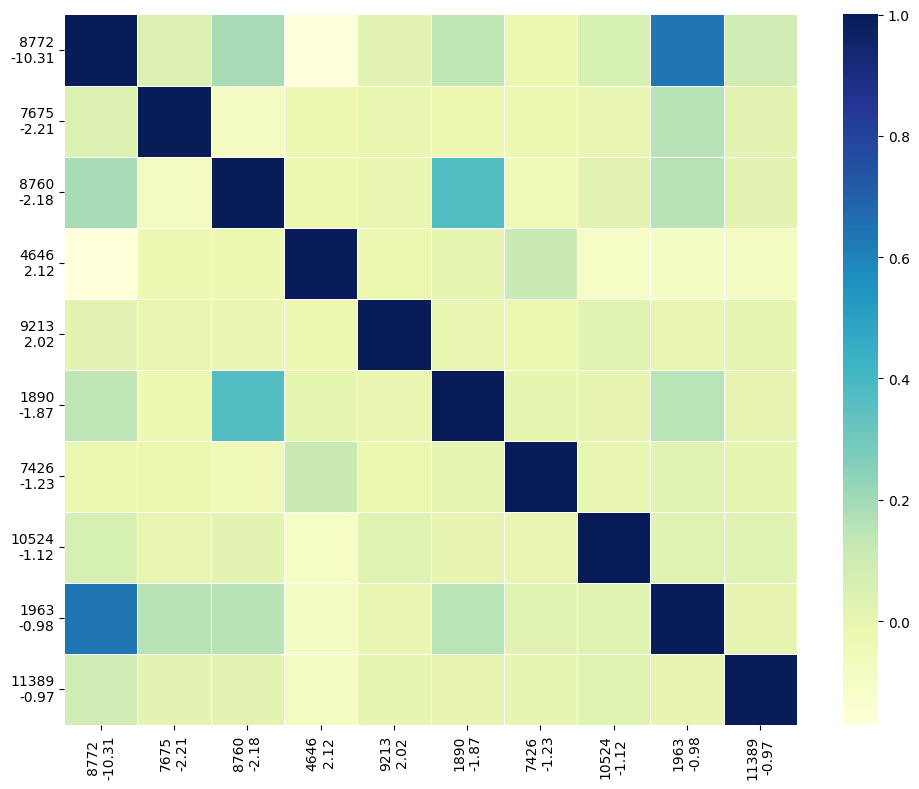

: 

In [61]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

ax = sns.heatmap(cosine_similarities, linewidth=0.5, cmap="YlGnBu", yticklabels=[f"{feature}\n{coef:.2f}"for feature, coef in zip(features, coefs)],
                 xticklabels=[f"{feature}\n{coef:.2f}"for feature, coef in zip(features, coefs)])
ax.figure.set_size_inches((10, 8))
ax.figure.tight_layout()
plt.savefig("cosine_similarities_translation_l_8.png")

In [50]:
np.argsort(-np.abs(Xs_difference_res[0]))[:10]

array([ 8772,  7675,  8760,  4646,  9213,  1890,  7426, 10524,  1963,
       11389])